In [1]:
import ads
import numpy as np
import matplotlib.pyplot as plt
import re
from unidecode import unidecode
from astropy.time import Time

In [2]:
#List of UDP Astro faculty
faculty = [
    "Aravena, M",
    "Assef, R",
    "Cieza, L",
    "Jenkins, J",
    "Johnston, E",
    "Jofre, P",
    "Mazzucchelli, C",
    "Prieto, J",
    "Ricci, C",
    "Yang, B",
    "Zurlo, A"
]

In [3]:
#List of UDP Astro students
students = [
    'Batalla Falcon, G', 
    'Brito Silva, D', 
    'De Brito Silva, D', 
    'Gonzalez Ruilova, C',
    'Gupta, K',
    'Hueichapan, E',
    'Jegatheesan, K',
    'Lambert, T', 
    'Nogueira, P', 
    'Pena Rojas, P',
    'Pessi, T',
    'Posses, A', 
    'Solimano, M',
    'Vitali, S',
    'Zewdie, D', 
    'de Brito Silva, D'
]

In [4]:
#People that have incorrectly had the affiliation in a paper.
black_listed = [
    'Albarracin, R',
    'Apostolovski, Y',
    'Avenhaus, H',
    'Baughman, J', 
    'Brodie, J',
    'Carbillet, M', 
    'Casassus, S', 
    'Chauvin, G', 
    'Desgrange, C', 
    'Gilmore, G', 
    'Honig, S',
    'Lopez, H',
    'Perez, S',
    'Phadke, K', 
    'Reuter, C',
    'Rouan, D',
    'Schmidt, T',
]

In [5]:
#Search for all papers from UDP in ADS in a given year.
def paper_search(year):
    q = ads.SearchQuery(aff="portales", year=year, fl=["author", "citation_count", "aff", "property", "doctype", "title", "pubdate","bibcode"], max_pages=100)
    ql = list(q)
    return ql

In [6]:
def proc_name(input_name):
    name = unidecode(input_name)
    name = re.sub("-"," ", name)
    name = re.sub("^(.*?\, .).*$",r"\1", name)
    return name

In [7]:
#Distribute publications between UDP authors.
def get_n_papers(ads_query_list, only_faculty=False):
    n_papers = dict()
    for paper in ads_query_list:

        #Only process refereed articles.
        if 'REFEREED' in paper.property and paper.doctype=='article':
            pass
        else:
            continue

        udp_auth = list()
        for k in range(len(paper.author)):
            name = proc_name(paper.author[k])
            if not only_faculty or name in faculty:
                if re.search("portales", paper.aff[k], flags=re.IGNORECASE):
                    if name in faculty or (re.search("astro", paper.aff[k], flags=re.IGNORECASE) and name not in black_listed):
                        udp_auth.append(name)
                        if k==0 and name in students:
                            break
        for name in udp_auth:
            if name in n_papers:
                n_papers[name] += 1./len(udp_auth)
            else:
                n_papers[name] = 1./len(udp_auth)
    return n_papers

In [8]:
ql = dict()
years = np.arange(2013, 2024)
for year in years:
    ql[year] = paper_search(year)

In [9]:
#Sort dividing papers as they go for incentivos.
n_papers1 = dict()
for year in years:
    n_papers1[year] = get_n_papers(ql[year])

In [10]:
#Print all authors that have used the UDP affiliation.
all_keys = list()
for year in years:
    keys = list(n_papers1[year].keys())
    all_keys.extend(keys)
np.unique(all_keys)

array(['Aguilera Gomez, C', 'Aravena, M', 'Assef, R', 'Batalla Falcon, G',
       'Bertrang, G', 'Bhowmik, T', 'Brisbin, D', 'Brito Silva, D',
       'Chavan, P', 'Cieza, L', 'De Brito Silva, D', 'Diaz Santos, T',
       'Dimopoulos, G', 'Elgueta, S', 'Gonzalez Lopez, J',
       'Gonzalez Ruilova, C', 'Guaita, L', 'Gupta, K', 'Hueichapan, E',
       'Infante, L', 'Jana, A', 'Jegatheesan, K', 'Jenkins, J',
       'Jiang, C', 'Jofre, P', 'Johnston, E', 'Kawamuro, T', 'Lambert, T',
       'Liao, M', 'Madler, T', 'Maia, M', 'Mazzucchelli, C', 'Muzic, K',
       'Nogueira, P', 'Pena Rojas, P', 'Pena, P', 'Pessi, T', 'Posses, A',
       'Prieto, J', 'Principe, D', 'Ramirez, R', 'Ricci, C',
       'Rojas Lilayu, A', 'Rojas, A', 'Romero Canizales, C',
       'Ruiz Rodriguez, D', 'Samadi Ghadim, A', 'Shablovinskaya, E',
       'Solimano, M', 'Temple, M', 'Tortosa, A', 'Tucci Maia, M',
       'Vitali, S', 'Yang, B', 'Zewdie, D', 'Zurlo, A',
       'de Brito Silva, D'], dtype='<U19')

In [11]:
#Calculate a linear correction for the final year. 
time_now = Time.now()
weights = np.ones(years.shape)
for i, year in enumerate(years):
    time_start_year = Time("{}-01-01 00:00:00".format(year))
    time_end_year = Time("{}-12-31 23:59:59".format(year))
    if time_now<time_end_year:
        weights[i] = (time_now-time_start_year).value/(time_end_year-time_start_year).value
print(weights)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [12]:
#Get the median for each year. 
median_papers1 = np.zeros(years.shape)
av_papers1 = np.zeros(years.shape)
for i, year in enumerate(years):
    aux = list()
    for name in faculty:
        if name in n_papers1[year]:
            aux.append(n_papers1[year][name])
    #If there is a faculty with no papers in the last year, it should be reflected here. 
    if year==years[-1]:
        for name in faculty:
            if name not in n_papers1[year]:
                aux.append(0)
    median_papers1[i] = np.median(aux)
    av_papers1[i] = np.average(aux)

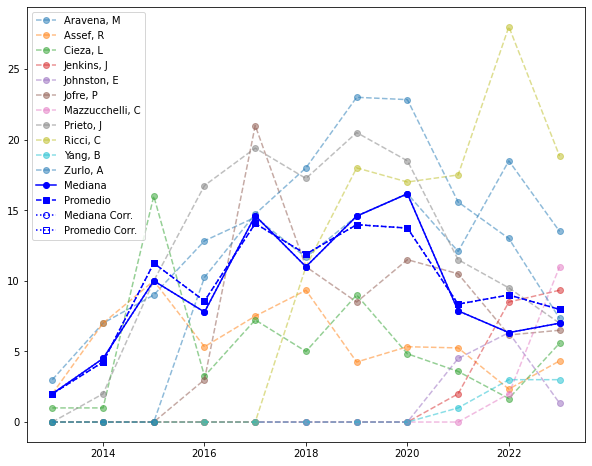

In [13]:
#Plot the evolution of faculty papers counting for incentivos. 
fig, ax = plt.subplots(1, figsize=(10,8))
for name in faculty:
    x = np.zeros(years.shape)
    for k,year in enumerate(years):
        if name in n_papers1[year]:
            x[k] = n_papers1[year][name]
    ax.plot(years, x, '--o', label=name, alpha=0.5)
ax.plot(years, median_papers1, '-bo', label='Mediana')
ax.plot(years, av_papers1, '--bs', label='Promedio')
ax.plot(years, median_papers1/weights, 'bo', label='Mediana Corr.', fillstyle='none', linestyle='dotted')
ax.plot(years, av_papers1/weights, 'bs', label='Promedio Corr.', fillstyle='none', linestyle='dotted')
ax.legend()
plt.show()

In [14]:
#Sort dividing papers only considering faculty.
n_papers2 = dict()
for year in years:
    n_papers2[year] = get_n_papers(ql[year], only_faculty=True)

In [15]:
#Get the median for each year. 
median_papers2 = np.zeros(years.shape)
av_papers2 = np.zeros(years.shape)
for i, year in enumerate(years):
    aux = list()
    for name in faculty:
        if name in n_papers2[year]:
            aux.append(n_papers2[year][name])
    #If there is a faculty with no papers in the last year, it should be reflected here. 
    if year==years[-1]:
        for name in faculty:
            if name not in n_papers2[year]:
                aux.append(0)
    median_papers2[i] = np.median(aux)
    av_papers2[i] = np.average(aux)

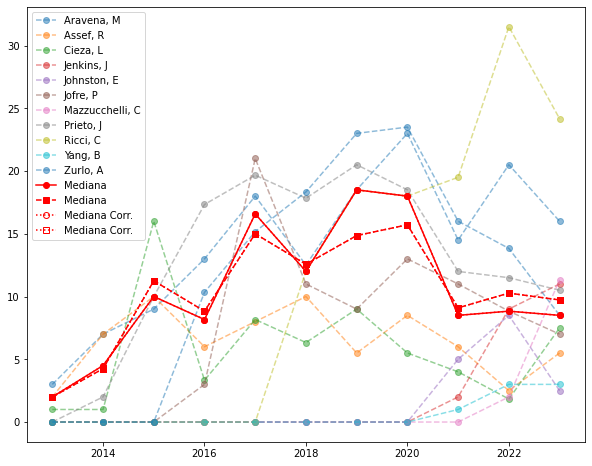

In [16]:
#Plot the evolution of all faculty papers. 
fig, ax = plt.subplots(1, figsize=(10,8))
for name in faculty:
    x = np.zeros(years.shape)
    for k,year in enumerate(years):
        if name in n_papers2[year]:
            x[k] = n_papers2[year][name]
    ax.plot(years, x, '--o', label=name, alpha=0.5)
ax.plot(years, median_papers2, '-ro', label='Mediana')
ax.plot(years, av_papers2, '--rs', label='Mediana')
ax.plot(years, median_papers2/weights, 'ro', label='Mediana Corr.', fillstyle='none',linestyle='dotted')
ax.plot(years, av_papers2/weights, 'rs', label='Mediana Corr.', fillstyle='none',linestyle='dotted')
ax.legend()
plt.show()

In [17]:
#Calculate the average number of papers a faculty member is responsible for. 
av_papers3 = np.zeros(years.shape)
nf = np.zeros(years.shape)
ntp = np.zeros(years.shape)
for i,year in enumerate(years):
    #Find how many faculty there were at UDP.
    for name in faculty:
        if name in n_papers1[year]:
            nf[i] += 1
    #In 2023, it has to be equal to the number of faculty, but it is possible a faculty has not published yet.
    if year==years[-1]:
        nf[i] = len(faculty)
    #Now, find the total number of astro papers for that year. 
    ntp[i] = np.sum(list(n_papers1[year].values()))
    #Now, get the average paper per faculty.
    av_papers3[i] = ntp[i]/nf[i]

In [18]:
for i, year in enumerate(years):
    print("{}: {} ({})".format(year, ntp[i], nf[i]))

2013: 6.0 (3.0)
2014: 18.0 (4.0)
2015: 59.0 (4.0)
2016: 72.0 (6.0)
2017: 111.0 (6.0)
2018: 110.99999999999999 (7.0)
2019: 118.0 (7.0)
2020: 126.0 (7.0)
2021: 117.0 (10.0)
2022: 128.0 (11.0)
2023: 131.0 (11.0)


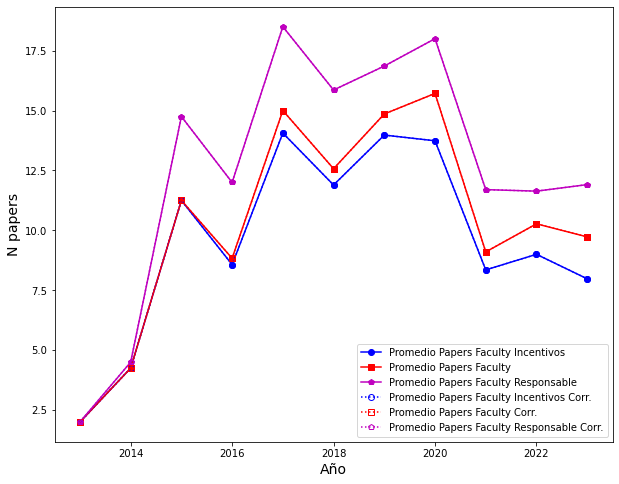

In [19]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.plot(years, av_papers1, '-bo', label="Promedio Papers Faculty Incentivos")
ax.plot(years, av_papers2, '-rs', label="Promedio Papers Faculty")
ax.plot(years, av_papers3, '-mp', label="Promedio Papers Faculty Responsable")
ax.plot(years, av_papers1/weights, 'bo', label="Promedio Papers Faculty Incentivos Corr.", fillstyle='none', linestyle='dotted')
ax.plot(years, av_papers2/weights, 'rs', label="Promedio Papers Faculty Corr.", fillstyle='none', linestyle='dotted')
ax.plot(years, av_papers3/weights, 'mp', label="Promedio Papers Faculty Responsable Corr.", fillstyle='none', linestyle='dotted')
ax.set_xlabel("Año", fontsize=14)
ax.set_ylabel("N papers", fontsize=14)
ax.legend()
plt.show()

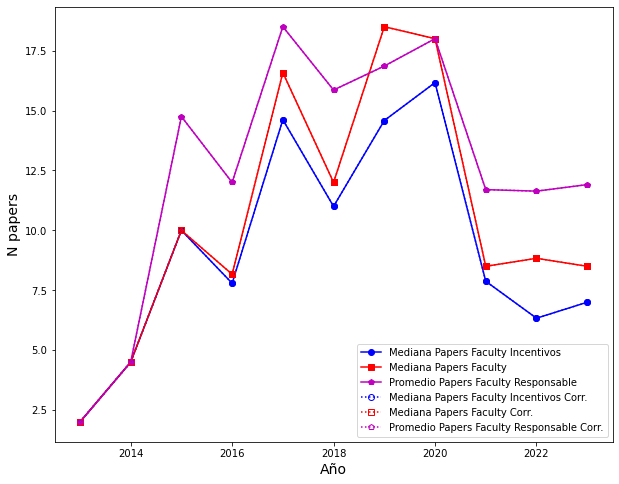

In [20]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.plot(years, median_papers1, '-bo', label="Mediana Papers Faculty Incentivos")
ax.plot(years, median_papers2, '-rs', label="Mediana Papers Faculty")
ax.plot(years, av_papers3, '-mp', label="Promedio Papers Faculty Responsable")
ax.plot(years, median_papers1/weights, 'bo', label="Mediana Papers Faculty Incentivos Corr.", fillstyle='none', linestyle='dotted')
ax.plot(years, median_papers2/weights, 'rs', label="Mediana Papers Faculty Corr.", fillstyle='none', linestyle='dotted')
ax.plot(years, av_papers3/weights, 'mp', label="Promedio Papers Faculty Responsable Corr.", fillstyle='none', linestyle='dotted')
ax.set_xlabel("Año", fontsize=14)
ax.set_ylabel("N papers", fontsize=14)
ax.legend()
plt.show()

In [21]:
#For each year find the ratio of papers between the first and second halve of the year.
n_paper_first_semester = np.zeros(len(years[1:-1]))
for i, year in enumerate(years[1:-1]):
    month = list()
    for paper in ql[year]:
        #Only process refereed articles.
        if 'REFEREED' in paper.property and paper.doctype=='article':
            pass
        else:
            continue
        for k in range(len(paper.author)):
            name = proc_name(paper.author[k])
            if re.search("portales", paper.aff[k], flags=re.IGNORECASE):
                if name in faculty or (re.search("astro", paper.aff[k], flags=re.IGNORECASE) and name not in black_listed):
                    month.append(float(paper.pubdate.split("-")[1]))
                    break
    month = np.array(month)
    n_paper_first_semester[i] = len(month[month<=6])/len(month)

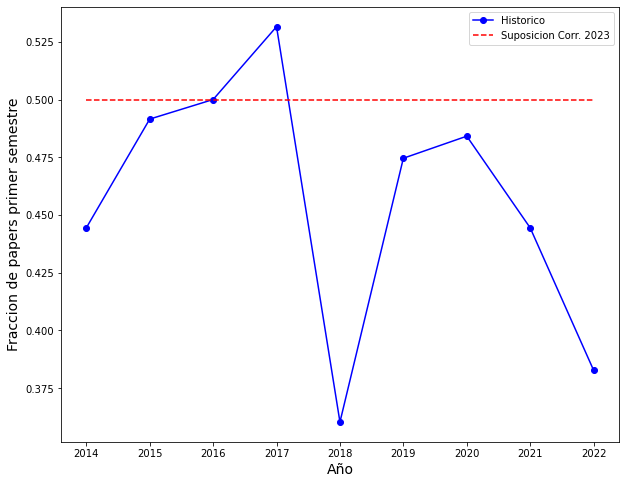

In [22]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.plot(years[1:-1], n_paper_first_semester, "-bo", label='Historico')
ax.plot(years[1:-1], 0.5*np.ones(years[1:-1].shape), '--r', label='Suposicion Corr. 2023')
ax.set_ylabel("Fraccion de papers primer semestre", fontsize=14)
ax.set_xlabel("Año", fontsize=14)
ax.legend()
plt.show()


In [27]:
from useful_functions import filter_papers
for year in [2022, 2023]:
    papers = filter_papers(ql[year])
    print(year, len(papers), "papers")
    for paper in papers:
        print(paper.bibcode)
    print()

2022 128 papers
2022ApJ...938...54R
2022ApJ...938...87K
2022ApJ...935...17S
2022A&A...666A.133Z
2022ApJ...939L..16Z
2022A&A...664A..46A
2022ApJS..261....2K
2022A&A...663A.144B
2022ApJ...938...67R
2022MNRAS.517.2214F
2022MNRAS.510.1248M
2022A&A...664A..94P
2022ApJS..262...49K
2022ApJ...939L..13A
2022ApJS..261....5M
2022A&A...668A.138H
2022A&A...664A.139D
2022ApJ...930..171H
2022A&A...666A..32X
2022MNRAS.516..391L
2022MNRAS.513.1557C
2022MNRAS.509.3599T
2022A&A...664A..31C
2022ApJ...927...65G
2022MNRAS.510..205P
2022MNRAS.509.4637D
2022MNRAS.517.6121V
2022A&A...666L..14D
2022A&A...660A.137G
2022ApJ...928..138P
2022ApJ...924...76A
2022MNRAS.514.6141J
2022A&A...658A..63M
2022A&A...666A..16C
2022A&A...665A..73M
2022A&A...658A.145B
2022A&A...666A.121R
2022ApJ...931..160B
2022MNRAS.514.6120J
2022ApJS..261....9A
2022ApJ...941..106F
2022A&A...666A.120G
2022MNRAS.515.3126I
2022MNRAS.512...58F
2022MNRAS.512..989D
2022MNRAS.513.3122S
2022MNRAS.516.5331M
2022MNRAS.515.1751W
2022MNRAS.513.2719V
2022